In [637]:
import pyedflib # ref: https://pyedflib.readthedocs.io/en/latest/
import pandas as pd
import numpy as np
import os
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy import signal
import yasa
import seaborn as sns
sns.set(font_scale=1.2)
import mne

In [638]:
read_folder = './clips/'
# subjects: 4001(E0, EC), 4032(E0, EP), 4191(E0, EP)
# 4742
id = 'SC400200'
psg_id = id + 'E0'
hypnogram_id = id + 'EC'

channels = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal']
channel = channels[1]
signal_path = os.path.join(read_folder, f'{psg_id}-PSG.edf')
label_path = os.path.join(read_folder, f'{hypnogram_id}-Hypnogram.edf')

#### Old pySleepEDF snippets


In [639]:
# read EDF files
if 'edf_label' and 'edf_label' in globals():
    del edf_signal, edf_label

edf_signal = pyedflib.EdfReader(signal_path)
edf_label = pyedflib.EdfReader(label_path)

# read data
annotations = edf_label.readAnnotations()
start = edf_signal.getStartdatetime()
signals, frequencies = edf_signal.getSignalLabels(), edf_signal.getSampleFrequencies()
data = []
for ch_idx, sig_name, freq in zip( range(len(signals)), signals, frequencies,):
    sig = edf_signal.readSignal(chn=ch_idx)
    idx = pd.date_range(  start=start, periods=len(sig), freq=pd.Timedelta(1 / freq, unit="s") )
    data += [pd.Series(sig, index=idx, name=sig_name)]


In [640]:
for ele in zip(signals, frequencies):
    print(ele)

('EEG Fpz-Cz', 100.0)
('EEG Pz-Oz', 100.0)
('EOG horizontal', 100.0)
('Resp oro-nasal', 1.0)
('EMG submental', 1.0)
('Temp rectal', 1.0)
('Event marker', 1.0)


# Try Raw mne

In [641]:
# raw = mne.io.read_raw_edf(signal_path, eog=[2], preload=True)
# # Downsample the data to 100 Hz
# raw.resample(100)
# # Apply a bandpass filter from 0.1 to 40 Hz
# raw.filter(0.1, 40)
# # Select a subset of EEG channels
# channel_names = raw.info['ch_names']
# # 2 eeg, 1 eog, all at 100Hz
# raw.pick(channel_names[:3])

In [642]:
# raw._data

In [643]:
# raw[2]

# COntinue

In [644]:
# create DataFrames
annotations_df = pd.DataFrame(annotations)
annotations_df = annotations_df.T
annotations_df.rename(columns={0: "Onset", 1: "Duration", 2:"Annotations"}, inplace=True)
signal_df =pd.concat(data[:3], axis=1)

In [645]:
signal_df['N1'] = 0

def check_sleep_stage(row):
    start_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1]))
    end_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1])) + timedelta(seconds = int(annotations_df['Duration'].iloc[1]))
    if start_time <= pd.to_datetime(row.name) < end_time:
        return int(1)
    else:
        return int(0)

signal_df['N1'] = signal_df.apply(check_sleep_stage, axis=1)

In [646]:
signal_df['N1_predict'] = 0

def check_sleep_stage(row):
    start_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1]))
    end_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1])) + timedelta(seconds = int(annotations_df['Duration'].iloc[1]))
    if start_time <= pd.to_datetime(row.name) < end_time:
        return int(1)
    else:
        return int(0)

signal_df['N1_predict'] = signal_df.apply(check_sleep_stage, axis=1)

In [647]:
print(annotations_df['Onset'].iloc[1])
annotations_df['Duration'].iloc[1]

600.0


90.0

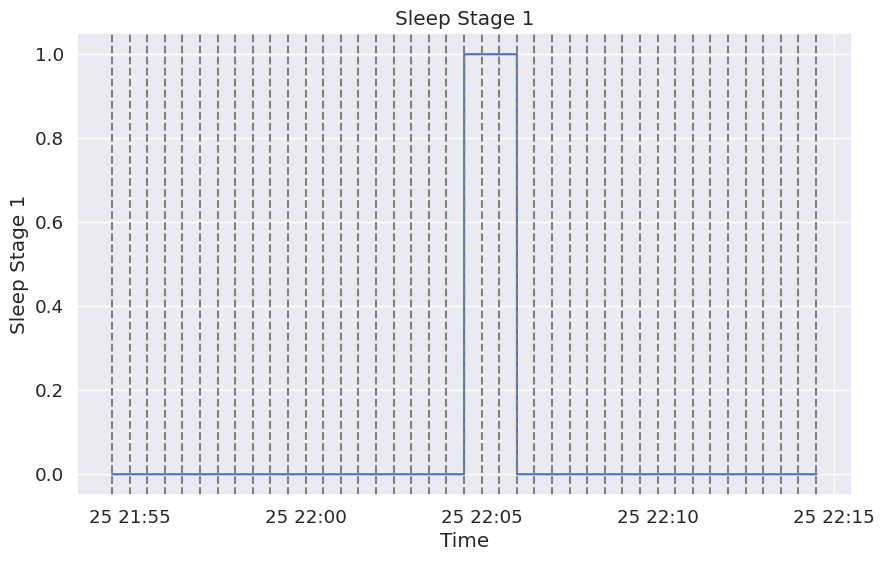

In [648]:
plt.figure(figsize=(10, 6))
# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['N1'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')
# 設定圖表標題和標籤
plt.title('Sleep Stage 1')
plt.xlabel('Time')
plt.ylabel('Sleep Stage 1')

# 顯示圖表
plt.show()
# plt.savefig('/fig/' + )

In [649]:
signal_df.shape

(120100, 5)

In [650]:
# rem = yasa.rem_detect(loc, roc, sf, hypno=None, include=4, amplitude=(50, 325), 
#                  duration=(0.3, 1.5), freq_rem=(0.5, 5), remove_outliers=False, 
#                  verbose=False)

# # Get the detection dataframe
# events = rem.summary()
# events.round(3)

In [651]:
signal_df

,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,N1,N1_predict
1989-04-25 21:54:30.000,-32.849817,-14.854212,-11.316239,0,0
1989-04-25 21:54:30.010,-15.640293,-12.596337,-23.373626,0,0
1989-04-25 21:54:30.020,-26.536264,-6.509890,-16.139194,0,0
1989-04-25 21:54:30.030,-21.750183,-6.804396,-25.785104,0,0
1989-04-25 21:54:30.040,-29.285714,-0.521612,-17.586081,0,0
...,...,...,...,...,...
1989-04-25 22:14:30.950,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.960,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.970,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.980,0.041758,0.067399,0.258852,0,0


In [652]:
from scipy import signal

sf=100.0
start_time = 1025
interval = 30
start_idx = int(start_time * sf)
end_idx = min(int((start_time + interval) * sf), len(signal_df))
data_range = signal_df.iloc[start_idx:end_idx]

In [653]:
# roc = signal_df.iloc[:,2]
# loc = -roc
# roc
# rem = yasa.rem_detect(loc, roc, sf, duration=(0, 0.6))
# events = rem.summary()
# events.round(3)
# times = np.arange(loc.size) / sf

In [654]:
# mask = rem.get_mask()
# mask

In [655]:
# loc_highlight = loc * mask[0, :]
# roc_highlight = roc * mask[1, :]

# loc_highlight[loc_highlight == 0] = np.nan
# roc_highlight[roc_highlight == 0] = np.nan

# plt.figure(figsize=(16, 4.5))
# plt.plot(times, loc, 'slategrey', label='LOC')
# plt.plot(times, roc, 'grey', label='ROC')
# plt.plot(times, loc_highlight, 'indianred')
# plt.plot(times, roc_highlight, 'indianred')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude (uV)')
# plt.xlim([0, times[-1]])
# plt.title('REM sleep EOG data')
# plt.legend()
# sns.despine()


In [656]:
write_folder = './plots/'
os.makedirs(write_folder, exist_ok=True)
pattern1 = '*-PSG.edf'
pattern2 = '*-Hypnogram.edf'

In [657]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import pandas as pd
def lol(signal_df, save_fig=False):
    num_columns = len(signal_df.columns)

    fig, axes = plt.subplots(num_columns, 1, figsize=(20, 12), sharex=True)

    # 迴圈遍歷每個欄位
    for i, column in enumerate(signal_df.columns):
        # 取得目前的軸
        ax = axes[i]

        # 繪製折線圖
        ax.plot(signal_df.index, signal_df[column])
        
        # 繪製虛線
        start_time = signal_df.index[0]
        end_time = signal_df.index[-1]
        interval = pd.Timedelta(seconds=30)
        current_time = start_time + interval
        while current_time < end_time:
            ax.axvline(x=current_time, linestyle='--', color='gray')
            current_time += interval

        # 設定軸的標籤
        ax.set_ylabel(column)
        loc = mdates.MinuteLocator(interval=1)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 設定圖表標題和共用 x 軸標籤
    fig.suptitle('Signal Visualization')
    axes[-1].set_xlabel('Time')
    # 調整子圖之間的間距
    plt.tight_layout()
    plt.ylim(0,10)
    # 顯示圖表
    if save_fig:
        plt.savefig(write_folder + psg_id.split('.')[0],bbox_inches='tight')
    else:
        plt.show()



In [658]:
signal_df.iloc[:,:]

,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,N1,N1_predict
1989-04-25 21:54:30.000,-32.849817,-14.854212,-11.316239,0,0
1989-04-25 21:54:30.010,-15.640293,-12.596337,-23.373626,0,0
1989-04-25 21:54:30.020,-26.536264,-6.509890,-16.139194,0,0
1989-04-25 21:54:30.030,-21.750183,-6.804396,-25.785104,0,0
1989-04-25 21:54:30.040,-29.285714,-0.521612,-17.586081,0,0
...,...,...,...,...,...
1989-04-25 22:14:30.950,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.960,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.970,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.980,0.041758,0.067399,0.258852,0,0


In [659]:
signal_df.iloc[60000,:]

EEG Fpz-Cz         6.966300
EEG Pz-Oz         -1.601465
EOG horizontal    38.842491
N1                 1.000000
N1_predict         1.000000
Name: 1989-04-25 22:04:30, dtype: float64

In [660]:
signal_df[signal_df['N1'] == 1]

,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,N1,N1_predict
1989-04-25 22:04:30.000,6.966300,-1.601465,38.842491,1,1
1989-04-25 22:04:30.010,3.707692,-6.509890,35.466422,1,1
1989-04-25 22:04:30.020,-0.467399,-8.375092,27.749695,1,1
1989-04-25 22:04:30.030,-0.976557,-8.669597,34.019536,1,1
1989-04-25 22:04:30.040,0.856410,-6.509890,37.395604,1,1
...,...,...,...,...,...
1989-04-25 22:05:59.950,15.112821,1.441758,5.081807,1,1
1989-04-25 22:05:59.960,16.436630,2.030769,8.940171,1,1
1989-04-25 22:05:59.970,12.363370,0.754579,14.245421,1,1
1989-04-25 22:05:59.980,6.355311,-1.895971,3.152625,1,1


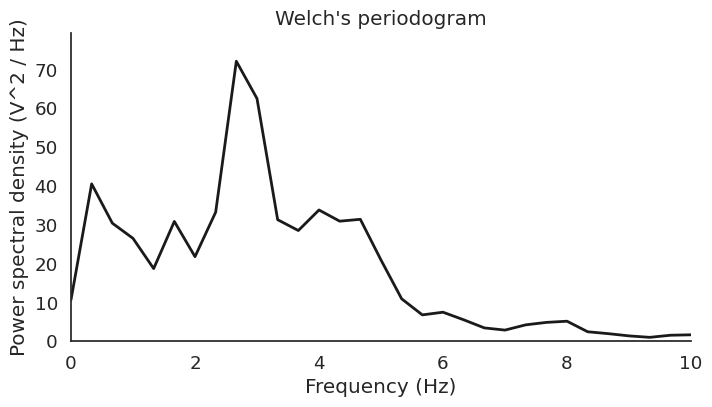

In [661]:



# Define window length (4 seconds)
win = 3 * sf
freqs, psd = signal.welch(signal_df.iloc[60000:63000,0], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 10])
sns.despine()

[False False  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]


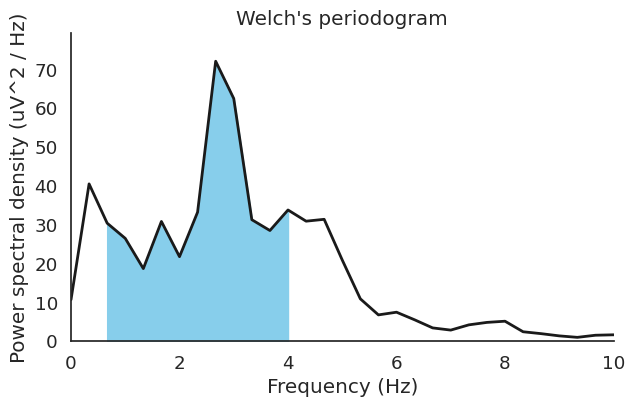

In [662]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)
print(idx_delta)
# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

## Alpha power

In [663]:
len(signal_df.iloc[:])

120100

In [664]:
# 0.01 s = 1 block
# all 36 block

In [665]:
index = []
# 0, 3000, 6000
N = signal_df.shape[0]

# threshold = 25 (OK)
for i in range(0, N, 3000):
    count = 0
    try:
        for j in range(3000):
            if(abs(signal_df.iloc[i+j,0]) < 25 and abs(signal_df.iloc[i+j-1,0]) < 25):
                count += 1
            else:
                count = 0
    except:
        pass
    if(count > 1500):
        index.append(i)
len(index)


0

In [666]:
print(index)

[]


In [667]:
signal_df['N1_predict'] = 0

def check_sleep_stage_predict(row, start_index, duration):
    start_time = start + timedelta(seconds = start_index)
    end_time = start + timedelta(seconds = start_index) + timedelta(seconds = duration)
    if start_time <= pd.to_datetime(row.name) < end_time:
        return int(1)
    else:
        return int(0)
    
if len(index) == 0:
    pass
elif len(index) == 1:
    signal_df['N1_predict'] = signal_df.apply(check_sleep_stage_predict, args=(int(index[0]/100), int(max(index)/100) + 1.5), axis=1) 
elif len(index) == 2:
    signal_df['N1_predict'] = signal_df.apply(check_sleep_stage_predict, args=(int(index[1]/100), int(max(index)/100)), axis=1)
else:
    signal_df['N1_predict'] = signal_df.apply(check_sleep_stage_predict, args=(int(index[1]/100), int((max(index)-index[1])/100)), axis=1)    

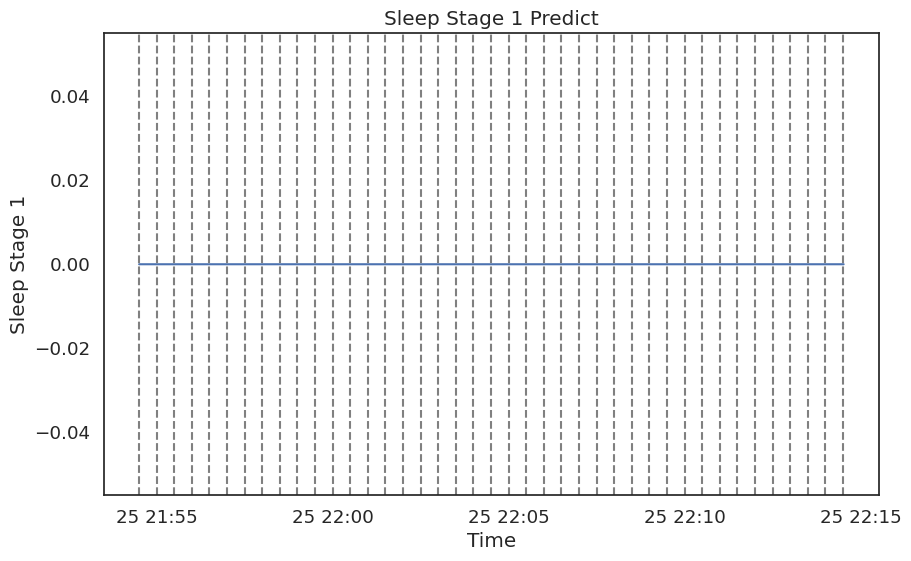

In [668]:
plt.figure(figsize=(10, 6))
# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['N1_predict'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')
# 設定圖表標題和標籤
plt.title('Sleep Stage 1 Predict')
plt.xlabel('Time')
plt.ylabel('Sleep Stage 1')

# 顯示圖表
plt.show()
# plt.savefig('/fig/' + )

In [669]:
index = []
# 0, 3000, 6000
N = signal_df.shape[0]
window = 30 * sf
thres = 8

for i in range(0, N, 3000):
    count = 0
    last = min(N, i+3000)
    temp = signal_df.iloc[i: last, 0]
    
    cond = abs(temp) < thres
    print(temp[cond])
    break
    
    if(count > sf/2):
        index.append(i)
len(index)


1989-04-25 21:54:30.110   -7.188278
1989-04-25 21:54:30.210   -0.976557
1989-04-25 21:54:30.220   -6.068132
1989-04-25 21:54:30.230   -6.271795
1989-04-25 21:54:30.270   -6.882784
                             ...   
1989-04-25 21:54:59.540   -5.966300
1989-04-25 21:54:59.590   -3.115018
1989-04-25 21:54:59.690   -5.355311
1989-04-25 21:54:59.910    7.169963
1989-04-25 21:54:59.920    6.151648
Name: EEG Fpz-Cz, Length: 541, dtype: float64


0

In [670]:
index

[]

In [671]:
c = abs(signal_df.iloc[:,0]) < 1
d = signal_df.iloc[:,3] == True
signal_df[c]

,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,N1,N1_predict
1989-04-25 21:54:30.210,-0.976557,-6.706227,-20.962149,0,0
1989-04-25 21:54:33.180,0.856410,0.852747,7.010989,0,0
1989-04-25 21:54:33.240,0.856410,-0.128938,8.940171,0,0
1989-04-25 21:54:33.280,0.958242,3.012454,10.869353,0,0
1989-04-25 21:54:33.810,0.041758,4.190476,0.258852,0,0
...,...,...,...,...,...
1989-04-25 22:14:30.950,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.960,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.970,0.041758,0.067399,0.258852,0,0
1989-04-25 22:14:30.980,0.041758,0.067399,0.258852,0,0


In [672]:
signal_df[d]

,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,N1,N1_predict
1989-04-25 22:04:30.000,6.966300,-1.601465,38.842491,1,0
1989-04-25 22:04:30.010,3.707692,-6.509890,35.466422,1,0
1989-04-25 22:04:30.020,-0.467399,-8.375092,27.749695,1,0
1989-04-25 22:04:30.030,-0.976557,-8.669597,34.019536,1,0
1989-04-25 22:04:30.040,0.856410,-6.509890,37.395604,1,0
...,...,...,...,...,...
1989-04-25 22:05:59.950,15.112821,1.441758,5.081807,1,0
1989-04-25 22:05:59.960,16.436630,2.030769,8.940171,1,0
1989-04-25 22:05:59.970,12.363370,0.754579,14.245421,1,0
1989-04-25 22:05:59.980,6.355311,-1.895971,3.152625,1,0


In [673]:
signal_df[c & d]

,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,N1,N1_predict
1989-04-25 22:04:30.020,-0.467399,-8.375092,27.749695,1,0
1989-04-25 22:04:30.030,-0.976557,-8.669597,34.019536,1,0
1989-04-25 22:04:30.040,0.856410,-6.509890,37.395604,1,0
1989-04-25 22:04:30.510,0.958242,3.895971,-19.997558,1,0
1989-04-25 22:04:30.610,0.550916,7.233700,-32.537241,1,0
...,...,...,...,...,...
1989-04-25 22:05:59.700,-0.772894,1.932601,2.188034,1,0
1989-04-25 22:05:59.730,0.041758,7.920879,-0.705739,1,0
1989-04-25 22:05:59.830,-0.467399,-4.350183,16.656899,1,0
1989-04-25 22:05:59.880,0.041758,0.165568,20.997558,1,0


In [674]:
signal_df.shape

(120100, 5)

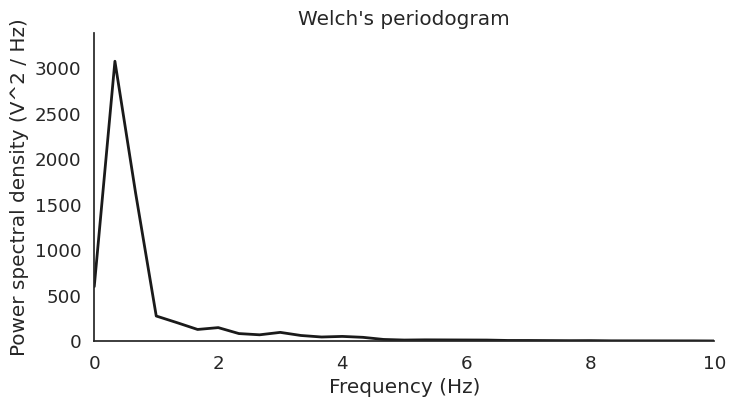

In [675]:
# Define window length (3 seconds)
win = 3 * sf
# freqs, psd = signal.welch(signal_df.iloc[60000:63000,0], sf, nperseg=win)
freqs, psd = signal.welch(signal_df.iloc[:3000,0], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 10])
sns.despine()

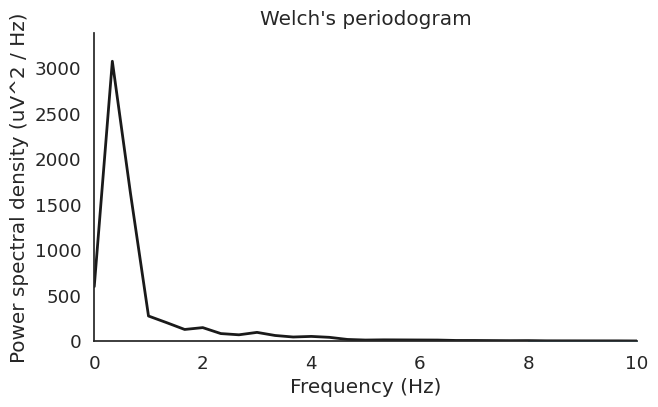

In [676]:
# Define alpha lower and upper limits
low, high = 8, 13

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)
# print(idx_alpha)
# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [677]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
alpha_power = simps(psd[idx_alpha], dx=freq_res)
print('Absolute alpha power: %.3f uV^2' % alpha_power)

Absolute alpha power: 16.520 uV^2


In [678]:
from scipy.integrate import simps
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
alpha_rel_power = alpha_power / total_power
print('Relative alpha power: %.3f' % alpha_rel_power)

Relative alpha power: 0.007


### Try to slide to find the power relative

In [679]:
len(signal_df)

120100

In [680]:
# signal_df[signal_df.iloc[:,0] < 0]

In [681]:
signal_df.iloc[3000:6000,0]

1989-04-25 21:55:00.000   -36.413919
1989-04-25 21:55:00.010   -74.397070
1989-04-25 21:55:00.020   -76.128205
1989-04-25 21:55:00.030   -54.336264
1989-04-25 21:55:00.040   -71.953114
                             ...    
1989-04-25 21:55:29.950    18.269597
1989-04-25 21:55:29.960    24.175824
1989-04-25 21:55:29.970    69.490842
1989-04-25 21:55:29.980    -7.697436
1989-04-25 21:55:29.990    -4.540659
Freq: 10L, Name: EEG Fpz-Cz, Length: 3000, dtype: float64

In [682]:
from scipy import signal

sf=100.0
sec = 30
sliding_interval = int(10 * sf)
interval = int(sf * sec)
plot = []
freq = {
    'alpha': (8, 12),
    'beta': (12, 30),
    'delta': (0.5, 4),
    'theta': (4, 8),
}

for start_time in range(0, len(signal_df), sliding_interval):
    start_idx = start_time
    end_idx = min(len(signal_df), start_idx + interval)
    data_range = signal_df.iloc[start_idx:end_idx]

    win = 4 * sf
    freqs, psd = signal.welch(data_range.iloc[:,0], sf, nperseg=win)

    dicts = {}
    for freq_name, (low, high) in zip(freq.keys(), freq.values()):

        idx = np.logical_and(freqs >= low, freqs <= high)

        # # ===============================
        from scipy.integrate import simps
        # Frequency resolution
        # print(freqs)
        freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

        # # Compute the absolute power by approximating the area under the curve
        power = simps(psd[idx], dx=freq_res)
        # print(f'Absolute {freq_name} power: {power} uV^2')

        # # Relative power (expressed as a percentage of total power)
        total_power = simps(psd, dx=freq_res)
        relative_power = power / total_power
        # print(f'Relative {freq_name} power: {relative_power}')

        dicts['Index'] = data_range.index[0]
        dicts[f'{freq_name}_pow'] = power
        dicts[f'{freq_name}_relative_pow'] = relative_power

        plot.append(dicts)

    df_plot = pd.DataFrame(plot, index = [x['Index'] for x in plot])
    df_plot.drop(columns=['Index'], inplace=True)

/home/jojo/mambaforge/envs/sleep-linear/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 400 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


In [683]:
df_plot

,alpha_pow,alpha_relative_pow,beta_pow,beta_relative_pow,delta_pow,delta_relative_pow,theta_pow,theta_relative_pow
1989-04-25 21:54:30,1.360275e+01,5.814478e-03,3.532655e+01,1.510028e-02,814.222761,0.348038,6.154457e+01,2.630714e-02
1989-04-25 21:54:30,1.360275e+01,5.814478e-03,3.532655e+01,1.510028e-02,814.222761,0.348038,6.154457e+01,2.630714e-02
1989-04-25 21:54:30,1.360275e+01,5.814478e-03,3.532655e+01,1.510028e-02,814.222761,0.348038,6.154457e+01,2.630714e-02
1989-04-25 21:54:30,1.360275e+01,5.814478e-03,3.532655e+01,1.510028e-02,814.222761,0.348038,6.154457e+01,2.630714e-02
1989-04-25 21:54:40,1.978501e+01,7.710011e-03,4.226953e+01,1.647199e-02,997.312347,0.388642,1.016723e+02,3.962064e-02
...,...,...,...,...,...,...,...,...
1989-04-25 22:14:20,1.400665e+01,1.452330e-02,1.737466e+01,1.801554e-02,713.111147,0.739415,5.866902e+01,6.083309e-02
1989-04-25 22:14:30,1.625305e-34,2.577793e-33,4.880442e-34,7.740558e-33,0.013135,0.208333,2.920132e-34,4.631435e-33
1989-04-25 22:14:30,1.625305e-34,2.577793e-33,4.880442e-34,7.740558e-33,0.013135,0.208333,2.920132e-34,4.631435e-33
1989-04-25 22:14:30,1.625305e-34,2.577793e-33,4.880442e-34,7.740558e-33,0.013135,0.208333,2.920132e-34,4.631435e-33


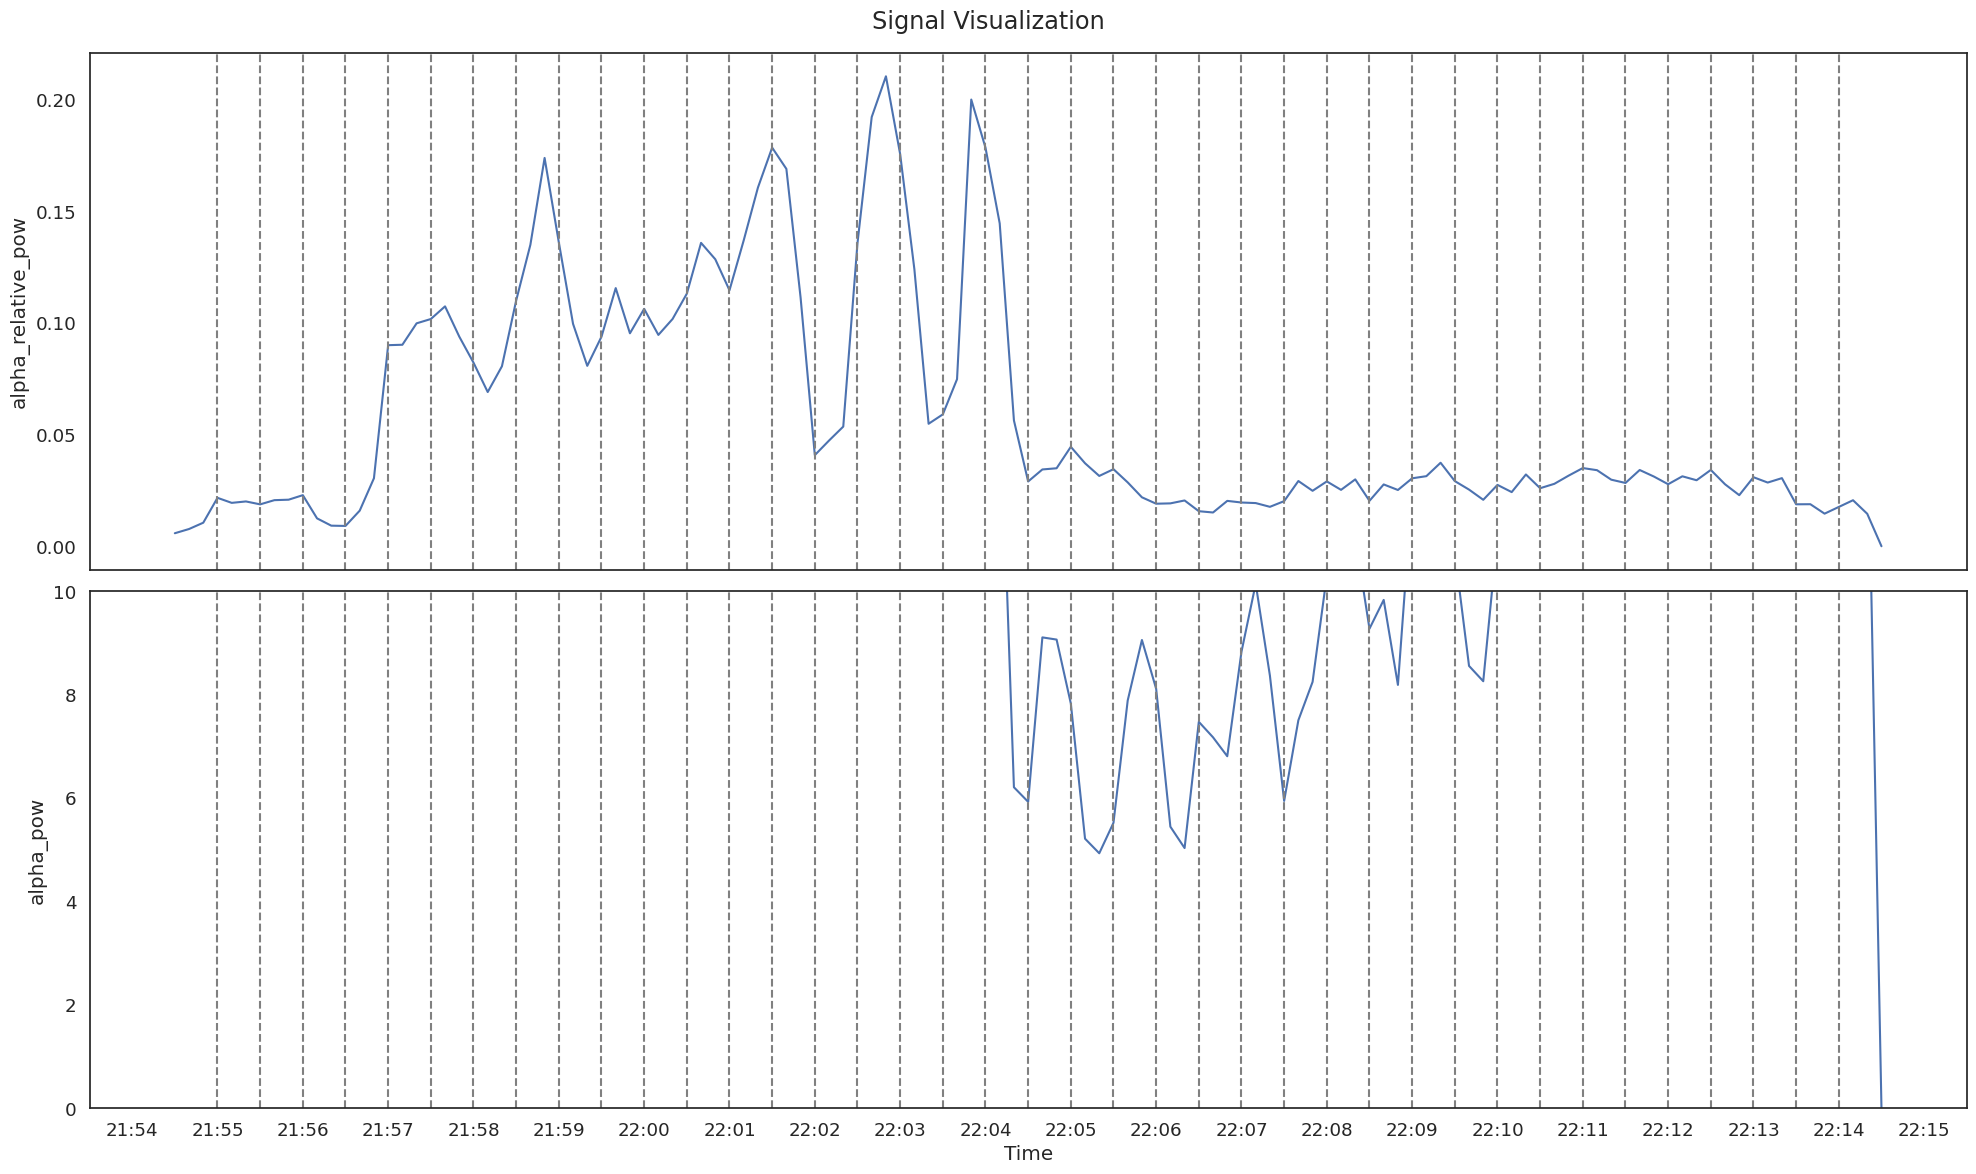

In [684]:
lol(pd.concat([df_plot.iloc[:,1],df_plot.iloc[:,0]], axis=1))

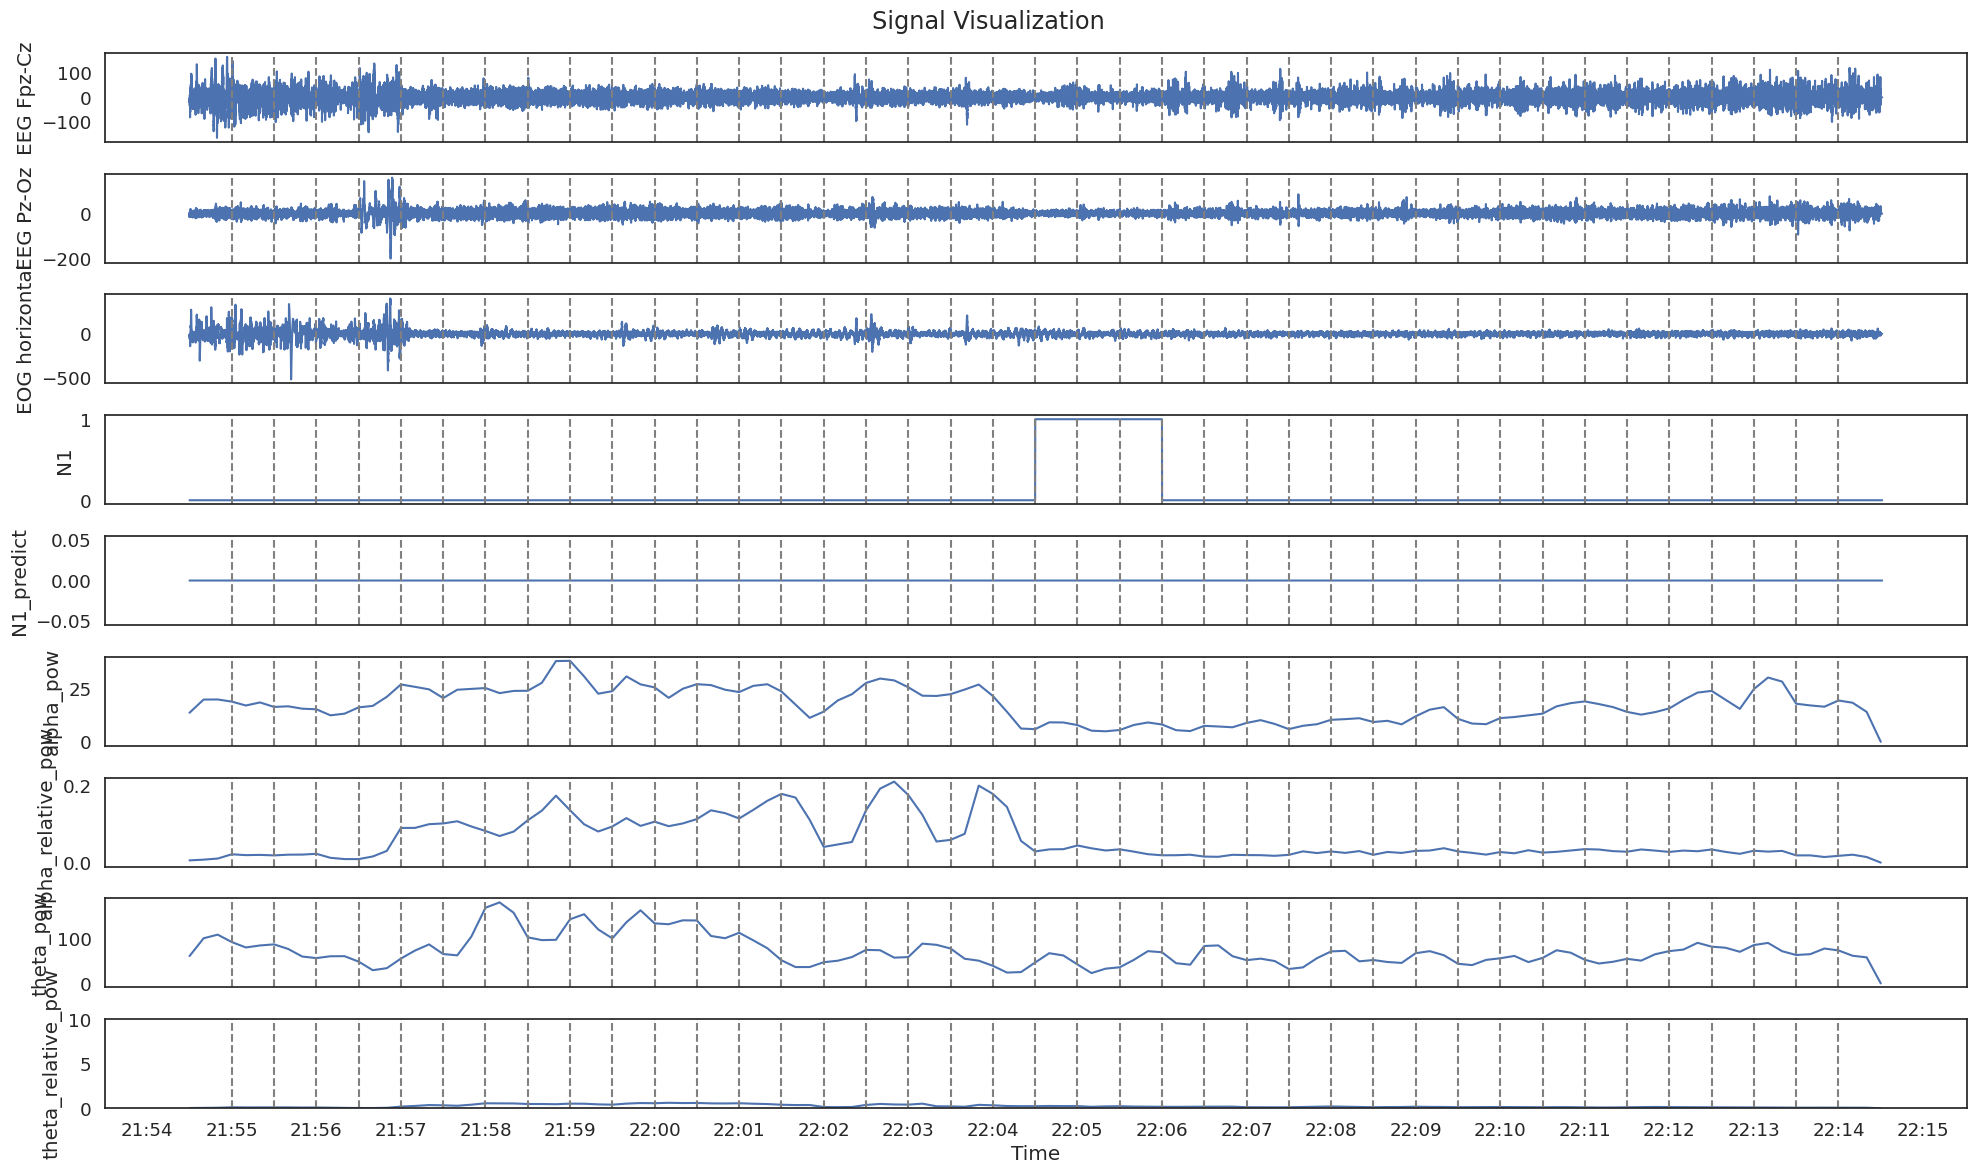

In [685]:
lol(pd.concat([signal_df, df_plot.iloc[:,:2], df_plot.iloc[:,-2:]], axis=0))

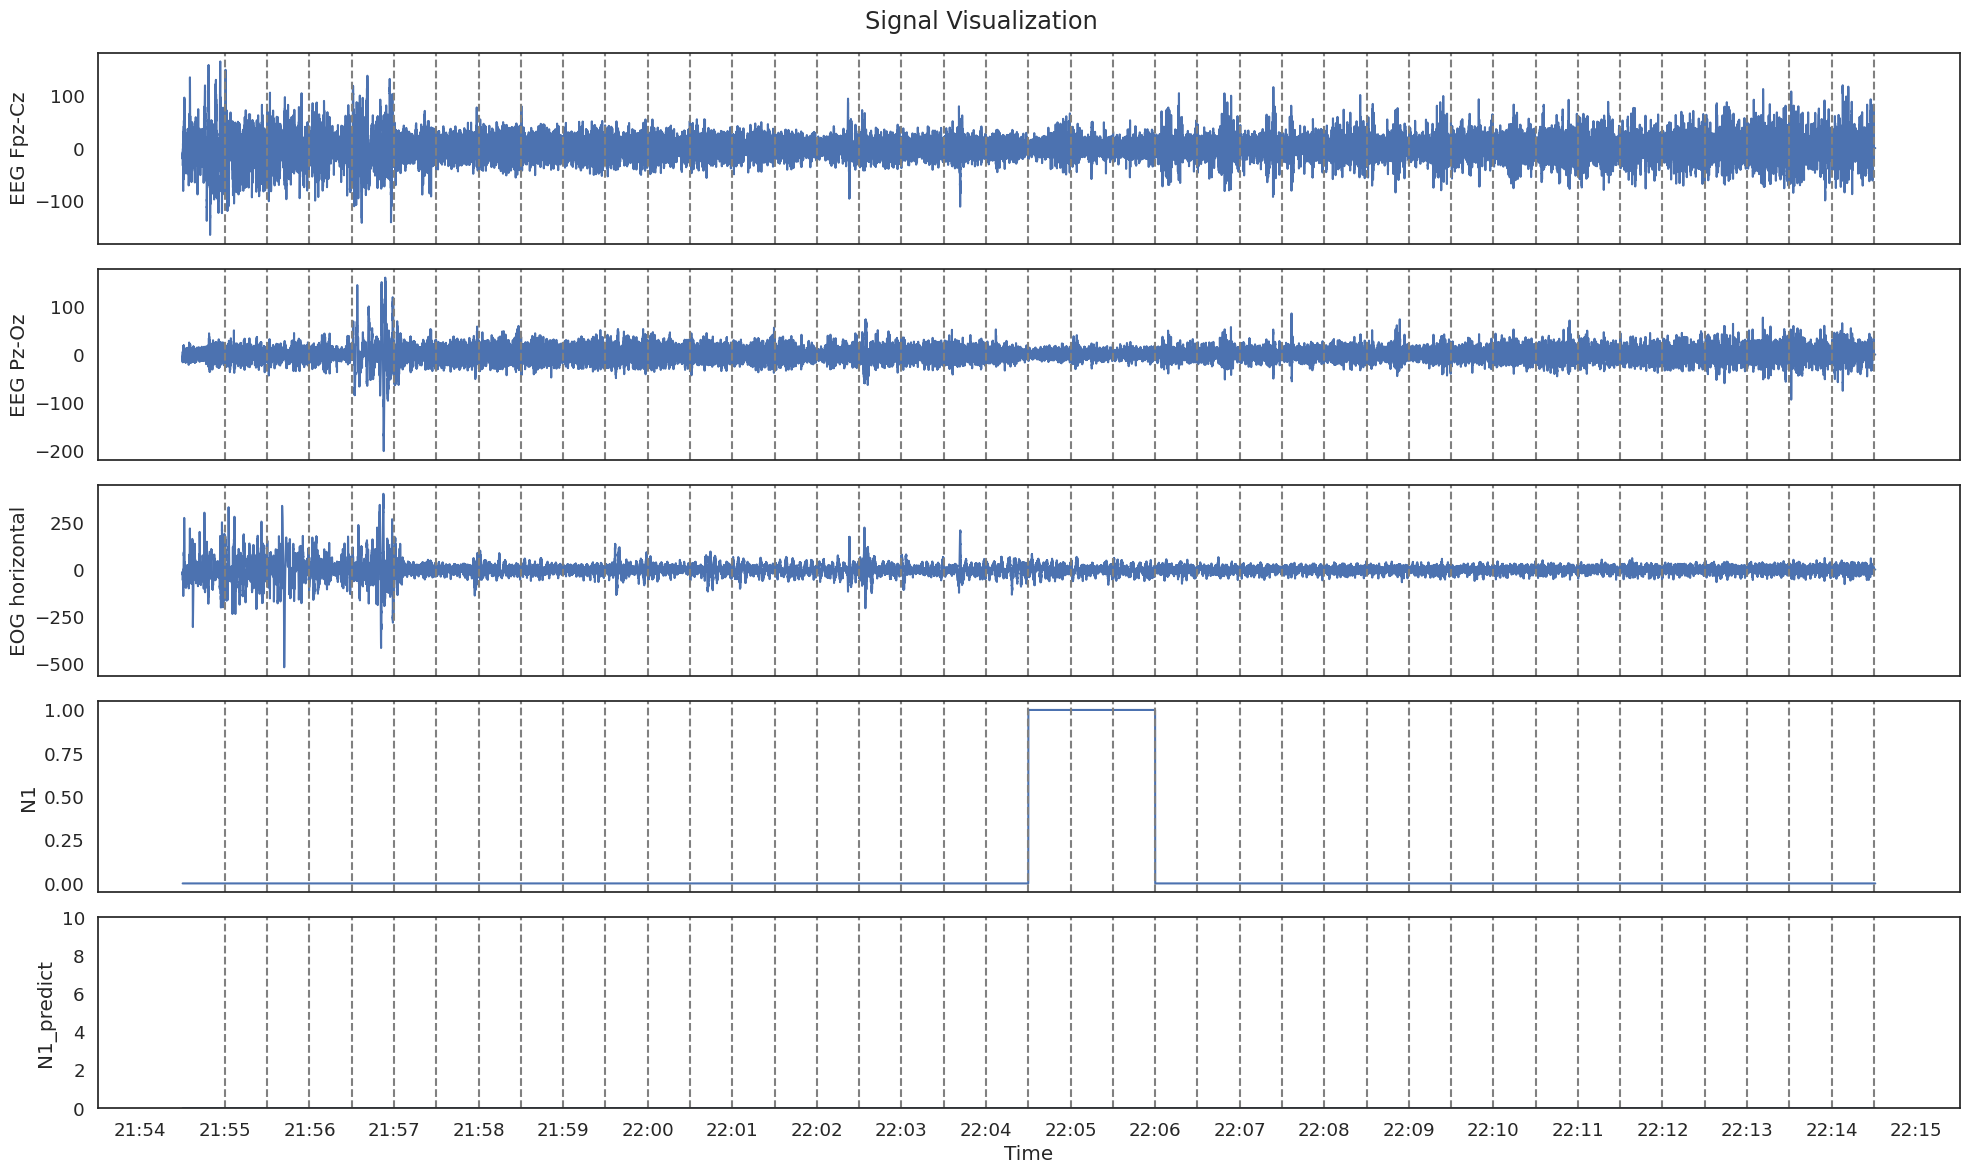

In [686]:
lol(pd.concat([signal_df], axis=0))